### This jupyter notebook is for the deep learning project(Group 20).
### dataset: https://github.com/Hua-YS/AID-Multilabel-Dataset
### Author: Cheng Huang, Zhiwei Zeng, Haoyu Guo

In this project, we will use the AID-Multilabel-Dataset, a dataset for multi-label classification of remote sensing images to do the multi-label classification task. However, due to the label positive, negative imblance probelm, we will build three some models based on three different loss functions(Binary cross entropy, Focal Loss, Asymmetric Loss) to evaluate the performance.


## Install required packages

In [ ]:
!pip3 install wheels
!pip3 install pandas
!python3 -m pip install matplotlib
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install pandas

## Import required packages

In [1]:
import torchvision.models as models
from torch import nn
import torch
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy
# Imports for calculating metrics
from PIL import *
from sklearn.metrics import f1_score, recall_score, precision_score
import torch.nn.functional as F
from matplotlib.pyplot import imshow
from torch.optim.lr_scheduler import StepLR

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Change to GPU

In [2]:
# It's very important here because we use Mac M1 chip to train so we use 'mps' here
# If you use Nvidia, please use CUDA
device = torch.device('mps')

In [3]:
device

device(type='mps')

## Global Variables

In [4]:
# AID Dataser
## Training set path
training_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_tr/'
## test set path
test_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_test/'
## the number of classes
num_class = 17
## csv path
data_csv = '/Users/huangcheng/Documents/newAIDDataset/newlabelfinal.csv'

batch_size =32
num_epoch = 14

## Import CSV Files

In [5]:
cats = pd.read_csv(data_csv, header=None)
cats = list(cats[0])
cats = cats[1:]

In [6]:
data = pd.read_csv(data_csv)
data.head()

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,airport_1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
1,airport_2,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0
2,airport_3,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
3,airport_4,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
4,airport_5,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0


## Create the model (VGG16 + ower own top layer)

In [7]:
def set_parameter_requires_grad(model):
    for name, param in model_ft.named_parameters():
        if "classifier.6.weight" in name or "classifier.6.bias" in name: #or "classifier.0.weight" in name or "classifier.0.bias" in name or "classifier.3.weight" in name or "classifier.3.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

In [8]:
## approach 1
# model_ft = models.vgg16(pretrained=True)
# set_parameter_requires_grad(model_ft, True)
# num_ftrs = model_ft.classifier[0].in_features  
# model_ft.classifier = nn.Linear(num_ftrs,num_class)
# model_ft.to(device)
# print(model_ft)

# # approach 2
# model_ft = models.vgg16(pretrained=True)
# set_parameter_requires_grad(model_ft, True)
# model_ft.classifier.add_module('add_linear', nn.Linear(1000, num_class))
# model_ft.to(device)
# print(model_ft)

# approach 3
model_ft = models.vgg16(pretrained=True)
set_parameter_requires_grad(model_ft)
model_ft.classifier[6] = nn.Linear(4096, num_class)
model_ft.to(device)
print(model_ft)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Image normalization layer with Data augmentation

In [9]:
# Transformations on the data
# transformations = transforms.Compose([transforms.Resize((224, 224)),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                      ])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5), 
        transforms.ColorJitter(brightness=0.1),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## DataLoader

In [10]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transformations, train):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
            train: flag to determine if train or val set
        """
        # Transforms
        self.transforms = transformations
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        self.train = train
        # First column contains the image paths
        if train:
            self.image_arr = (self.data_info.iloc[0:2400, 0])
        else:
            self.image_arr = (self.data_info.iloc[2400:2700, 0])
  
        self.image_arr = np.asarray(self.image_arr)
        # Second column is the labels
        if train:
            self.label_arr = np.asarray(self.data_info.iloc[0:2400, 1:])
        else:
            self.label_arr = np.asarray(self.data_info.iloc[2400:2700, 1:])

        # Third column is for an operation indicator
        #self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.label_arr)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = training_path+self.image_arr[index] + ".jpg"
        # Open image
        img_as_img = Image.open(single_image_name).convert('RGB')

        if self.transforms is not None and self.train == True:
            img_as_tensor = self.transforms['train'](img_as_img)
        if self.transforms is not None and self.train == False:
            img_as_tensor = self.transforms['val'](img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [11]:
# Define a dictionary of dataset
# one for train and one for validation
image_datasets = {'train': CustomDatasetFromCSV(data_csv, data_transforms, True), 
                 'val': CustomDatasetFromCSV(data_csv, data_transforms, False)}


In [12]:
# Define data loader
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=0) for x in ['train', 'val']}

## Map image name and label

In [13]:
# all_data_csv = '/Users/huangcheng/Documents/newAIDDataset/multilabel.csv'
# all_data_csv = '/Users/huangcheng/Downloads/hbku/labels/labels_train.csv'
labels = pd.read_csv(data_csv)
name_label_dic = {}
labels.iloc[1]
for i in tqdm(range(labels.shape[0])):
  label = []
  for j in range(1, num_class+1):
    label.append(labels.iloc[i][j])
  name_label_dic[labels.iloc[i][0]] = label


100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1874.63it/s]


## Calculate Accuracy Function

In [14]:
# Function for calculating accuracy of the model
def calc_accuracy(preds, labels):
    return (np.sum(np.around(preds.cpu().detach().numpy()) == labels.cpu().detach().numpy()))

## Plot Loss Function

In [15]:
def draw_plot(train_loss, val_loss, num_epoch):
    epoch_range = range(1, num_epoch+1)
    plt.plot(epoch_range, train_loss)
    plt.plot(epoch_range, val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()


## Evaluate the model(Precision, Recall, F1 Score)

In [16]:
def experiment_evaluate(model_ft):
    y_true = []
    y_predict = []
    
    for img_name in tqdm(os.listdir(test_path)):
        if img_name.endswith(".jpg") == False:
          continue;
        img_path = test_path + img_name
        sample_img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms['val'](sample_img)
        img_tensor = img_tensor.reshape(1, 3, 224, 224)
        true_label = name_label_dic[img_name[:-4]]
        y_true.append(true_label)
        model_ft.eval()
        with torch.no_grad():
            img_tensor_tensor = img_tensor.to(device)
            outputs = model_ft(img_tensor_tensor)
            outputs = torch.sigmoid(outputs)
            preds_label = np.around(outputs.cpu().detach().numpy())[0].tolist()
            y_predict.append(preds_label)
    
    precision = precision_score(y_true, y_predict, average=None, zero_division=1)
    recall = recall_score(y_true, y_predict, average=None, zero_division=1)
    f1 = f1_score(y_true, y_predict, average=None, zero_division=1)
    
    precision_micro = precision_score(y_true, y_predict, zero_division=1, average = 'micro')
    recall_micro = recall_score(y_true, y_predict, zero_division=1, average = 'micro')    
    f1_micro = f1_score(y_true, y_predict, zero_division=1, average = 'micro')
    
    precision_macro = precision_score(y_true, y_predict, zero_division=1, average = 'macro')
    recall_macro = recall_score(y_true, y_predict, zero_division=1, average = 'macro')    
    f1_macro = f1_score(y_true, y_predict, zero_division=1, average = 'macro')
    
    return precision, recall, f1, precision_micro, recall_micro, f1_micro


## Train Model Function

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epoch, loss_name, scheduler=None):
  '''
      model: Model need to train
      dataloaders: dataloaders to get data
      criterion: Loss function(we will use three differernt loss function, Binary Cross Entropy, Focal Loss and ASL)
      optimizer: we use Adam here
      num_epoch: the default num_epoch is 25
  '''
  since = time.time()
  val_acc_history = []
  loss_train = []
  loss_val = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epoch):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        # In validation phase, we will not calculate the gradiant, so set it to false can reduce memory consumption
        with torch.set_grad_enabled(phase == 'train'): 
          # Get model outputs and calculate loss
          outputs = model(inputs)
          if loss_name == "bce":
            outputs = torch.sigmoid(outputs)
          loss = criterion(outputs, labels)
          preds = outputs
          
          if phase == 'train':
            loss.backward() # back propagation to calculate the grad
#             if loss_name == 'focal':
#                 scheduler.step() # optimize the weight
#             else:
            optimizer.step() # optimize the weight
          
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += calc_accuracy(preds, labels.data)
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)      
      if phase == 'train':
        loss_train.append(epoch_loss)
      if phase == 'val':
        loss_val.append(epoch_loss)
      print('epoch:{} {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  model.load_state_dict(best_model_wts)
  return model, loss_train, loss_val

## Here we train the model with Adam and Binary Cross Entropy

In [20]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
bce_optimizer = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay = 1e-3)
# Binary Cross Entropy loss function
bce_criterion = torch.nn.BCELoss().to(device)
bce_model, bce_train_loss, bce_val_loss = train_model(model_ft, dataloaders_dict, bce_criterion, bce_optimizer, num_epoch=num_epoch, loss_name = "bce")


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:0 train Loss: 0.4023


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:0 val Loss: 0.3249


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:1 train Loss: 0.2992


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:1 val Loss: 0.2860


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.21it/s]


epoch:2 train Loss: 0.2666


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:2 val Loss: 0.2665


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:3 train Loss: 0.2504


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:3 val Loss: 0.2512


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:4 train Loss: 0.2387


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:4 val Loss: 0.2419


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:5 train Loss: 0.2287


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:5 val Loss: 0.2345


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:6 train Loss: 0.2228


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:6 val Loss: 0.2275


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:7 train Loss: 0.2163


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:7 val Loss: 0.2232


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:8 train Loss: 0.2115


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:8 val Loss: 0.2188


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:9 train Loss: 0.2088


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


epoch:9 val Loss: 0.2147


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:10 train Loss: 0.2050


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:10 val Loss: 0.2122


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:11 train Loss: 0.2021


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:11 val Loss: 0.2107


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:12 train Loss: 0.1988


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:12 val Loss: 0.2082


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:13 train Loss: 0.1963


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]

epoch:13 val Loss: 0.2050


## Plot the Loss with Binary Cross Entropy

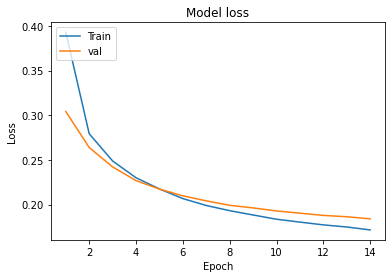

In [35]:
draw_plot(bce_train_loss, bce_val_loss, num_epoch)

## Save Model to Local

In [21]:
# Here, we save the model we trained before for future experiment, therefore, we do not need to retrain.
torch.save(bce_model,"/Users/huangcheng/Documents/DeepLearningProjectModels/bce.pth")

## Evluate the Model with Binary Cross Entropy

In [77]:
precision, recall, f1, precision_micro, recall_micro, f1_micro  = experiment_evaluate(bce_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 21.75it/s]

[1.         0.70807453 0.94977169 0.91705069 1.         0.7
 0.78571429 0.76923077 0.93495935 1.         0.96581197 1.
 0.90909091 0.71428571 0.83333333 0.91967871 0.61904762]
[0.2        0.7972028  0.98113208 0.96135266 0.         0.18918919
 0.42307692 0.47619048 0.9787234  0.         0.9826087  0.72
 0.45454545 0.43478261 0.5        0.94238683 0.42391304]
[0.33333333 0.75       0.96519722 0.93867925 0.         0.29787234
 0.55       0.58823529 0.95634096 0.         0.97413793 0.8372093
 0.60606061 0.54054054 0.625      0.93089431 0.50322581]
precision_micro =  0.8662382103453516
recall_micro =  0.5567708327081469
f1_micro =  0.611572169449039


## Focal Loss Function Class

In [49]:
class FocalLoss(nn.Module):

    def __init__(self, alpha=.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        return loss.mean()

## Here we train the model with Adam and Focal Loss

In [51]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
focal_optimizer = optim.Adam(model_ft.parameters(), lr=0.0005, weight_decay = 1e-3)
# Learning Rate schedule
# scheduler = StepLR(focal_optimizer, step_size=7, gamma = 0.1)
# Binary Cross Entropy loss function
focal_criterion = FocalLoss(alpha=.55, gamma=2).to(device)
focal_model, focal_train_loss, focal_val_loss = train_model(model_ft, dataloaders_dict, focal_criterion, focal_optimizer, num_epoch=num_epoch,loss_name = "focal")#, scheduler=scheduler)

100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.16it/s]


epoch:0 train Loss: 0.0387


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:0 val Loss: 0.0291


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:1 train Loss: 0.0292


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:1 val Loss: 0.0267


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:2 train Loss: 0.0272


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:2 val Loss: 0.0266


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:3 train Loss: 0.0262


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:3 val Loss: 0.0268


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:4 train Loss: 0.0250


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:4 val Loss: 0.0249


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:5 train Loss: 0.0250


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:5 val Loss: 0.0252


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:6 train Loss: 0.0244


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:6 val Loss: 0.0251


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:7 train Loss: 0.0236


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:7 val Loss: 0.0257


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:8 train Loss: 0.0236


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:8 val Loss: 0.0248


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:9 train Loss: 0.0236


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:9 val Loss: 0.0247


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:10 train Loss: 0.0232


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:10 val Loss: 0.0249


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:11 train Loss: 0.0230


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:11 val Loss: 0.0247


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:12 train Loss: 0.0233


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:12 val Loss: 0.0247


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:13 train Loss: 0.0230


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]

epoch:13 val Loss: 0.0246


## Plot the Loss with Focal Loss

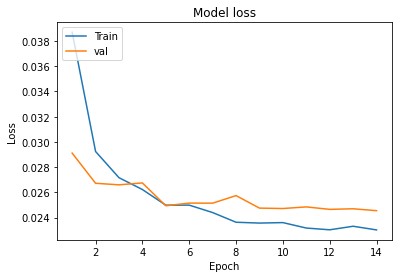

In [52]:
draw_plot(focal_train_loss, focal_val_loss, num_epoch)

## Evluate the Model with Focal Loss

In [53]:
precision, recall, f1, precision_micro, recall_micro, f1_micro = experiment_evaluate(focal_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 22.30it/s]


[1.         0.67901235 0.89699571 0.90909091 0.5        0.5
 0.64705882 0.48       0.88973384 1.         0.93061224 1.
 0.88888889 0.61904762 0.85714286 0.89097744 0.52325581]
[0.3        0.76923077 0.98584906 0.96618357 0.16666667 0.27027027
 0.42307692 0.57142857 0.99574468 0.         0.99130435 0.76
 0.36363636 0.56521739 0.6        0.97530864 0.48913043]
[0.46153846 0.72131148 0.93932584 0.93676815 0.25       0.35087719
 0.51162791 0.52173913 0.93975904 0.         0.96       0.86363636
 0.51612903 0.59090909 0.70588235 0.93123772 0.50561798]
precision_micro =  0.8414481897627965
recall_micro =  0.8668810289389067
f1_micro =  0.8539752929996832


## Save Model to Local

In [56]:
# Here, we save the model we trained before for future experiment, therefore, we do not need to retrain.
torch.save(focal_model,"/Users/huangcheng/Documents/DeepLearningProjectModels/focal.pth")

## ASL Loss Function Class

In [18]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


## Here we train the model with Adam and ASL

In [19]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
asl_optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
# Binary Cross Entropy loss function
asl_criterion = AsymmetricLoss(gamma_neg=1.35, gamma_pos=1, clip=0.0005).to(device)
asl_model, asl_train_loss, asl_val_loss = train_model(model_ft, dataloaders_dict, asl_criterion, asl_optimizer, num_epoch=num_epoch, loss_name='asl')

100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:0 train Loss: 93.4980


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:0 val Loss: 69.8277


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:1 train Loss: 68.9057


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:1 val Loss: 61.3523


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:2 train Loss: 61.8566


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:2 val Loss: 57.2238


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:3 train Loss: 57.8849


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:3 val Loss: 54.5077


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:4 train Loss: 56.0920


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:4 val Loss: 52.6103


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:5 train Loss: 53.6073


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:5 val Loss: 51.4556


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:6 train Loss: 52.1406


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:6 val Loss: 50.4811


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:7 train Loss: 50.6935


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:7 val Loss: 48.4516


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:8 train Loss: 49.7960


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


epoch:8 val Loss: 48.1062


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.21it/s]


epoch:9 train Loss: 48.3688


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:9 val Loss: 48.2020


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:10 train Loss: 48.4539


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


epoch:10 val Loss: 47.8775


100%|███████████████████████████████████████████| 75/75 [01:01<00:00,  1.21it/s]


epoch:11 train Loss: 47.6071


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:11 val Loss: 46.7994


100%|███████████████████████████████████████████| 75/75 [01:01<00:00,  1.21it/s]


epoch:12 train Loss: 47.1192


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:12 val Loss: 46.5843


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:13 train Loss: 46.8361


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]

epoch:13 val Loss: 46.1193


## Plot the model with ASL loss

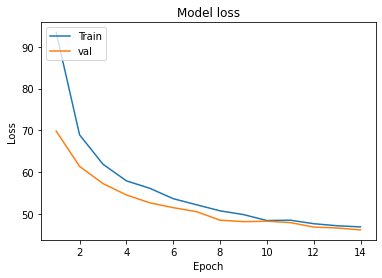

In [21]:
draw_plot(asl_train_loss, asl_val_loss, num_epoch)

## Evaluate the Model with ASL

In [23]:
precision, recall, f1, precision_micro, recall_micro, f1_micro  = experiment_evaluate(asl_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 22.15it/s]


[1.         0.57746479 0.81782946 0.81927711 1.         0.6
 1.         1.         0.79863481 1.         0.8172043  1.
 1.         1.         1.         0.83219178 0.45      ]
[0.         0.86013986 0.99528302 0.98550725 0.         0.16216216
 0.03846154 0.         0.99574468 0.         0.99130435 0.
 0.         0.         0.         1.         0.29347826]
[0.         0.69101124 0.89787234 0.89473684 0.         0.25531915
 0.07407407 0.         0.88636364 0.         0.89587426 0.
 0.         0.         0.         0.90841121 0.35526316]
precision_micro =  0.7716012084592145
recall_micro =  0.8212218649517685
f1_micro =  0.795638629283489


## Save Model to Local

In [25]:
# Here, we save the model we trained before for future experiment, therefore, we do not need to retrain.
torch.save(asl_model,"/Users/huangcheng/Documents/DeepLearningProjectModels/asl.pth")